In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.decomposition import NMF, TruncatedSVD

### ALS Class 정의

In [2]:
# http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html

class ALS:
    def __init__(self, factors=10, iterations=20, reg=0.01): # 하이퍼 파라미터 지정
        self.factors = factors # latent vector의 수
        self.iterations = iterations # 하나를 고정하고 학습하고, 또 다른 하나를 고정하고 학습하는 과정을 얼마나 반복할 것인지?
        self.reg = reg # regulation 을 얼마나 강하게 할 것 인지
        
    def fit(self, ratings): # 모델 적합 -> 평점 행렬 입력
        # 랜덤으로 user수 *  latent factor 형태의 행렬 생성
        self.user_factors = np.random.random((ratings.shape[0], self.factors))
        # 랜덤으로 item수 * latent factor 형태의 행렬 생성
        self.item_factors = np.random.random((ratings.shape[1], self.factors))
        
        
        # 사전에 지정한 iteration 수에 맞춰 교차로 als_step 진행
        
        for _ in range(self.iterations):
            # user_factors 먼저 업데이트
            self.user_factors = self.als_step(ratings, self.user_factors, self.item_factors)
            # item_factors 업데이트
            self.item_factors = self.als_step(ratings.T, self.item_factors, self.user_factors)
            
    def als_step(self, ratings, solve_vecs, fixed_vecs):

        # norm equation - 업데이트 되지 않을 user/item feautre의 공분산 matrix
        # feature가 주어진 (고정된) 상태에서 최적의 해를 찾아 그 행렬을 새로운 factors로 사용
        # 가령, user_factors가 고정되어 있을 떄는 최적의 item_factors를 구하고, 반대도 마찬가지
        
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        
        return solve_vecs
    
    def predict(self):
        pred = self.user_factors.dot(self.item_factors.T)
        
        return pred

###  Data Load

In [3]:
# 데이터가 없는 경우
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'
# df = pd.read_excel(url)

# 데이터가 존재하는 경우
data_path = "./data/online_retail/Online Retail.xlsx"
df = pd.read_excel(data_path)

<hr>

#### Data check

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Data prerpocessing

#### Category 형태로 변환

In [8]:
df['CustomerID'] = df['CustomerID'].astype('category') # user id
df['StockCode'] = df['StockCode'].astype('category') # item id

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  category      
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  category      
 7   Country      541909 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 27.2+ MB


#### 너무 적은 인터렉션을 갖는 유저/아이템은 배제
- 학습과 예측이 잘 되지 않음

In [10]:
interation_counts = df.groupby("CustomerID").StockCode.count()
df = df[df["CustomerID"].isin(interation_counts[interation_counts > 10].index)]

item_counts = df.StockCode.value_counts()
df = df[df.StockCode.isin(item_counts[item_counts > 10].index)]

In [11]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


#### Making pivot table
- 데이터가 너무 커지면 문제가 생김

In [12]:
pivot = df.pivot_table(index="CustomerID", columns="StockCode", fill_value=0, aggfunc="size") # 개수를 구하기 위해서 aggfunc size 사용
pivot

StockCode,10002,10080,10120,10125,10133,10134,10135,11001,15030,15034,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Implicit Dataset으로 변환
- 샀는지 아닌지만 중요하기 때문

In [13]:
pivot = (pivot > 0).astype(int)

In [14]:
pivot

StockCode,10002,10080,10120,10125,10133,10134,10135,11001,15030,15034,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train

#### Data split
- MF에서는 다른 방식
- SVM을 사용하기 때문에 나중에 복원이 안됨

In [15]:
test_ratio = 0.2
train = pivot.copy()
test = np.zeros(pivot.shape)

for user in range(pivot.shape[0]): # user마다 일정 비율을 test에 두겠음`
    test_interactions = np.random.choice(pivot.values[user, :].nonzero()[0], # pivot table의 user 의 0dl dksls colum들 중
                                       size=int(test_ratio*np.sum(pivot.values[user, :])), # 0이 아닌 값의 수 * test ratio
                                       replace=False)
    train.values[user, test_interactions] = 0.
    test[user, test_interactions] = pivot.values[user, test_interactions]

In [16]:
pivot.values[1, :].nonzero()

(array([  12,   40,   62,  100,  141,  143,  221,  263,  267,  280,  332,
         347,  413,  611,  649,  724,  761,  795,  887,  888, 1009, 1012,
        1068, 1069, 1084, 1115, 1226, 1227, 1228, 1229, 1230, 1265, 1270,
        1271, 1280, 1335, 1337, 1340, 1390, 1400, 1458, 1531, 1532, 1533,
        1558, 1559, 1560, 1561, 1562, 1604, 1605, 1606, 1607, 1608, 1635,
        1651, 1771, 1817, 1897, 1905, 1963, 1964, 1979, 1987, 1988, 1989,
        1990, 1991, 1992, 1994, 2079, 2101, 2112, 2120, 2215, 2216, 2217,
        2273, 2289, 2295, 2298, 2300, 2344, 2519, 2544, 2757, 2766, 2767,
        2809, 2828, 3158, 3164, 3190, 3389, 3391, 3392, 3423, 3424, 3578,
        3579, 3580, 3750], dtype=int64),)

In [17]:
pivot.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
pivot

StockCode,10002,10080,10120,10125,10133,10134,10135,11001,15030,15034,...,M,PADS,POST,S,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,m
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Convert train and test matrix into sparse matrix


In [19]:
train_csr = coo_matrix(train.values)
test_csr = coo_matrix(test)

#### Model training

In [20]:
n_latent_factors = 20

model : SVD

In [21]:
# 1. using sklearn Truencated svd
svd= TruncatedSVD(n_components=n_latent_factors, random_state=42)
train_svd = svd.fit_transform(train_csr)
svd_pred = svd.inverse_transform(svd.transform(test_csr))

In [22]:
train_svd.shape

(4372, 20)

<hr>


In [23]:
# 2. using svds from scipy
u, sigma, vt = svds(train_csr.astype(float), n_latent_factors)
svd_pred = np.dot(u, np.dot(np.diag(sigma), vt))

In [24]:
print(f'shapes of the matrices: {u.shape, sigma.shape, vt.shape}')

shapes of the matrices: ((4372, 20), (20,), (20, 4070))


model: NMF

In [25]:
model = NMF(n_components=n_latent_factors, init="random", random_state=0)
W = model.fit_transform(train_csr)
H = model.components_
nmf_pred = np.dot(W, H)

C:\Users\jmjhj\anaconda3\envs\rs\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


model: ALS

In [26]:
# train ALS model
als = ALS(factors = n_latent_factors, iterations=100, reg=0.01)
als.fit(train_csr)

# predict
als_pred = als.predict()

### Evaluate

In [27]:
at_k = 10

# Make sure the predicted scores are in the range [0, 1]
predicted_svd = (svd_pred - svd_pred.min()) / (svd_pred.max() - svd_pred.min())
predicted_nmf = (nmf_pred - nmf_pred.min()) / (nmf_pred.max() - nmf_pred.min())
predicted_als = (als_pred - als_pred.min()) / (als_pred.max() - als_pred.min())

In [28]:
print(predicted_svd.shape)

(4372, 4070)


In [29]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for SVD
svd_rmse = np.sqrt(mean_squared_error(test_csr.toarray(), predicted_svd))
print('SVD RMSE: ', svd_rmse)

# Calculate RMSE for NMF
nmf_rmse = np.sqrt(mean_squared_error(test_csr.toarray(), predicted_nmf))
print('NMF RMSE: ', nmf_rmse)

# Calculate RMSE for ALS
als_rmse = np.sqrt(mean_squared_error(test_csr.toarray(), predicted_als))
print('ALS RMSE: ', als_rmse)


SVD RMSE:  0.4288252919920111
NMF RMSE:  0.05325615881801344
ALS RMSE:  0.40142047927126356


### 참고

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
corr = np.corrcoef(svd_pred)
corr.shape

C:\Users\jmjhj\anaconda3\envs\rs\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\jmjhj\anaconda3\envs\rs\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(4372, 4372)

In [32]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

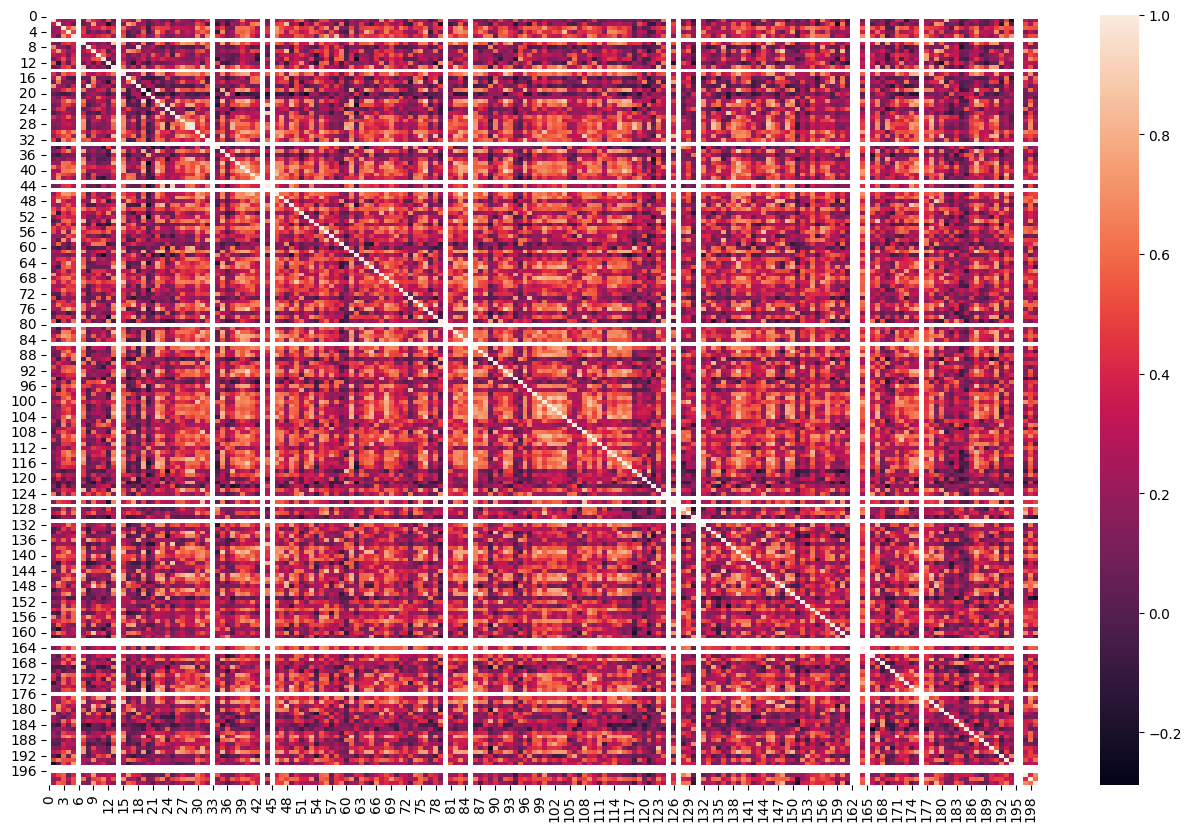

In [33]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)
plt.show()

### 구현 예정


특정 user와 비슷한 성향을 가진 사람들이 선호하는 것 추천